<h1 align = 'center'>Document Classification</h1>

<h3>Avinash Pasupulate</h3>
<br>
<a href='mailto:avinash.pasupulate@gmail.com'><i>avinash.pasupulate@gmail.com</i></a>

Status
* Improving accuracy from 
<br>
43%  - initial accuracy,
<br>
55.3% - Optimized min_df & max_df in tfidf,
<br>
75.7% - Included more data, Optimizing hypparms in logreg
<br>
79.20%  - Optimizing hypparms in random forest
<br>
80%  - Adding K Means cluster labels and optimizing with k at 65
<br>
current score 80%  
* Optimizing hyperparameters

In [1]:
import os
import re
import copy
import string
import random
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import sparse
from sklearn.svm import SVC
from bs4 import BeautifulSoup
from sklearn import preprocessing
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

stopwrd = set(stopwords.words('english'))
cwd = os.getcwd()
random.seed(2889)

Listing all files in directory

In [2]:
#os.listdir(cwd+r'/data/reuters21578')

In [3]:
data = cwd+r'/data/reuters21578'

In [4]:
#creating a list of filenames to import

l = list(range(0,22))
m = []
for i in l:
    if len(str(i))==1:
        filename = '/reut2-00'+str(i)+'.sgm'
        m.append(filename)
    else:
        filename = '/reut2-0'+str(i)+'.sgm'
        m.append(filename)

In [5]:
#create dataframe with extracted text

doc = pd.DataFrame()
for i in m:
    with open(data+i, 'rb') as f:
        text = BeautifulSoup(f.read(), 'html.parser')
        documents = text.findAll('reuters')
        l=[]
        for a in documents:
            try:
                topic = a.topics.find_all('d')[0].contents[0]
                place = a.places.find_all('d')[0].contents[0]
                title = a.title.contents[0].lower()
                body = re.sub('\n', ' ', a.body.contents[0].lower())
                l.append([topic, place, title, body, i])
            except:
                pass
        doc = doc.append(l, ignore_index = True, sort = True)
doc.columns = ['topic', 'place', 'title', 'body', 'filename']

In [6]:
print("unique categories in text: {:} in {:} rows"
      .format(len(doc['topic'].unique()),len(doc['topic'])))

unique categories in text: 80 in 10327 rows


The extracted text can be preprocessed but most of the stages are included in the tfid vectorizer functions.

#text pre-processing functions (not used)
lemmatizer = WordNetLemmatizer()

def remnum(x):
    return re.sub('[0-9]', '', x)

def rempunc(x):
    return ''.join([w for w in x if w not in string.punctuation])

def cltxt(x):
    tok = [rempunc(remnum(i)) for i in x.split() 
     if (i not in stopwrd)]
    cltxt1 = [lemmatizer.lemmatize(i) for i in tok if len(i)>2]
    return ' '.join(i for i in cltxt1)

In [7]:
encoder = preprocessing.LabelEncoder()
tfidf_vector = TfidfVectorizer(analyzer = 'word',
                               token_pattern = u'(?ui)\\b\\w*[a-z]+\\w*\\b',
                               max_features = 100,
                               lowercase = True,
                               stop_words = 'english',
                               max_df = 0.5,
                               min_df = 0.01
                              )

In [8]:
doc['label'] = encoder.fit_transform(doc['topic'])

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    doc['body'], doc['label'], test_size = 0.25,
    random_state = 28)
actual = y_test

In [11]:
#change variable type and pass
#tfidf_vector = tfidf_vector.fit(doc['body'])

In [12]:
#only transform on the test set
X_train_tfidf_raw = tfidf_vector.fit_transform(X_train)
X_test_tfidf_raw = tfidf_vector.transform(X_test)

In [13]:
X_train_df = pd.DataFrame(X_train_tfidf_raw.todense(),
             columns = tfidf_vector.get_feature_names())

X_test_df = pd.DataFrame(X_test_tfidf_raw.todense(),
             columns = tfidf_vector.get_feature_names())

<h3>K Means Clustering</h3>

In [14]:
kmod = KMeans(n_clusters = 65, random_state = 28)
ktrainfit = kmod.fit(X_train_df)
ktestfit = ktrainfit.predict(X_test_tfidf_raw)

In [15]:
X_train_df['train_clust'] = ktrainfit.labels_[:,None]
X_test_df['train_clust'] = ktestfit[:,None]

In [16]:
X_train_tfidf = X_train_df
X_test_tfidf = X_test_df

In [17]:
#X_train_tfidf = sparse.hstack((X_train_tfidf_raw, ktrainfit.labels_[:,None]))
#X_test_tfidf = sparse.hstack((X_test_tfidf_raw, ktestfit[:,None]))

<h3>Support Vector Machine Classifier</h3>

In [18]:
svcmod = SVC(kernel = 'poly',
             C=1,
             gamma = 'auto')
svcfit = svcmod.fit(X_train_tfidf, y_train)
svc_pred = svcfit.predict(X_test_tfidf)
accuracy_score(actual, svc_pred)

0.6673121611154144

<h3>Multinomial Naive Bayes Classifier</h3>

In [19]:
mnb_mod = MultinomialNB(alpha = 0.01)
mnb_fit = mnb_mod.fit(X_train_tfidf, y_train)
mnb_score = accuracy_score(actual, mnb_fit.predict(X_test_tfidf))
mnb_score

0.7327652982184353

<h3>Multiclass Regression Classifier</h3>

In [20]:
logmod = LogisticRegression(multi_class='multinomial',
                            solver='saga',
                            C=1,
                            penalty = 'l2',
                            random_state = 28,
                            max_iter = 1000,
                            n_jobs = -1)
logfit = logmod.fit(X_train_tfidf, y_train)
accuracy_score(actual, logfit.predict(X_test_tfidf))
#0.773431448489543

/Users/Avinash/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.762587141750581

<h3>K Nearest Neighbors Classifier</h3>

In [21]:
knnmod = KNeighborsClassifier(n_neighbors = 10,
                              n_jobs = -1)
knnfit = knnmod.fit(X_train_tfidf, y_train)
accuracy_score(actual, knnfit.predict(X_test_tfidf))
#0.7467079783113865

0.7292796281951975

<h3>Random Forest Classifier</h3>

In [22]:
rfmod = RandomForestClassifier(n_estimators = 250,
                               random_state = 28,
                               criterion = 'gini',
                               bootstrap = False,
                               max_depth = 100,
                               n_jobs = -1)
rffit = rfmod.fit(X_train_tfidf, y_train)
accuracy_score(actual, rffit.predict(X_test_tfidf))

0.8001549186676995

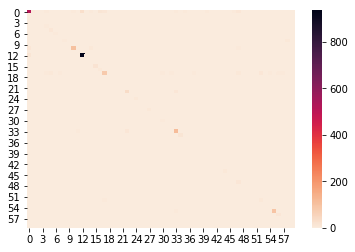

In [23]:
#too many labels conf mat not easy to intepret
sns.heatmap(confusion_matrix(actual, rffit.predict(X_test_tfidf)).T, fmt='d', 
           cmap = sns.cm.rocket_r)

Use more optimization methods (cv, bagging, boosting (improved bootstrapping) & stacking), and extract more information from data to try improve on accuracy > 80% (80% is good).